# Homework 6

https://github.com/DataTalksClub/data-engineering-zoomcamp/blob/main/cohorts/2023/week_6_stream_processing/homework.md

Please implement a streaming application, for finding out popularity of PUlocationID across green and fhv trip datasets.
Please use the datasets [fhv_tripdata_2019-01.csv.gz](https://github.com/DataTalksClub/nyc-tlc-data/releases/tag/fhv) 
and [green_tripdata_2019-01.csv.gz](https://github.com/DataTalksClub/nyc-tlc-data/releases/tag/green)

PS: If you encounter memory related issue, you can use the smaller portion of these two datasets as well, 
it is not necessary to find exact number in the  question.

Your code should include following
1. Producer that reads csv files and publish rides in corresponding kafka topics (such as rides_green, rides_fhv)
2. Pyspark-streaming-application that reads two kafka topics
   and writes both of them in topic rides_all and apply aggregations to find most popular pickup location.

1. Run [docker-compose.yml](https://github.com/Avisprof/DataEngineering_Zoomcamp/blob/main/week_6_stream_processing/docker/docker-compose.yml) for start kafka and spark
<br>`docker-compose up -d`

2. Run script [producer_green.py](https://github.com/Avisprof/DataEngineering_Zoomcamp/blob/main/week_6_stream_processing/kafka-python-stream/producer_green.py):
<br>`python producer_green.py`

3. Run script [producer_fhv.py](https://github.com/Avisprof/DataEngineering_Zoomcamp/blob/main/week_6_stream_processing/kafka-python-stream/producer_fhv.py):
<br>`python producer_fhv.py`

4. Let's take a look at Topics into CONFLUENT (http://localhost:9021)

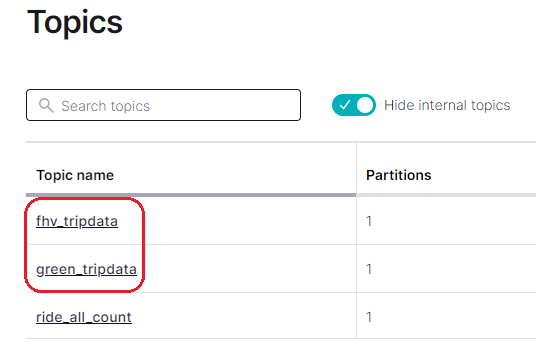

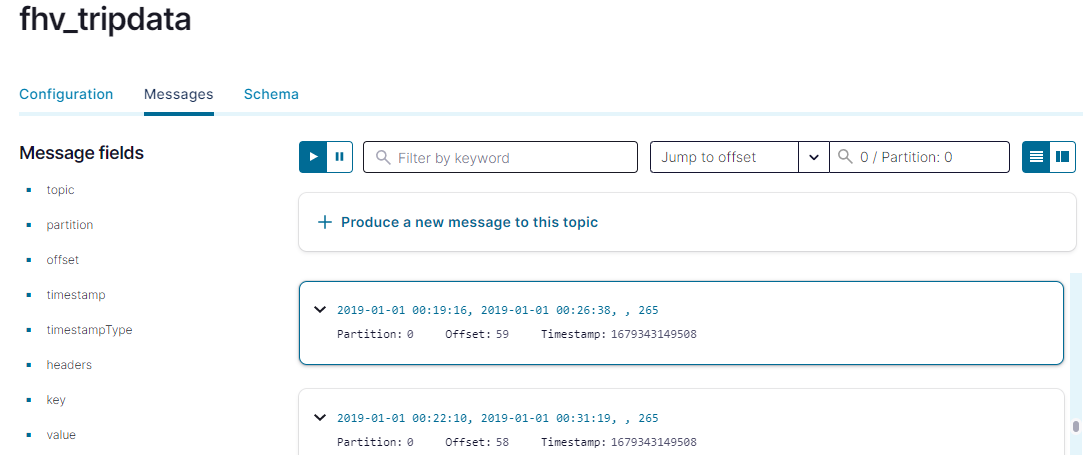

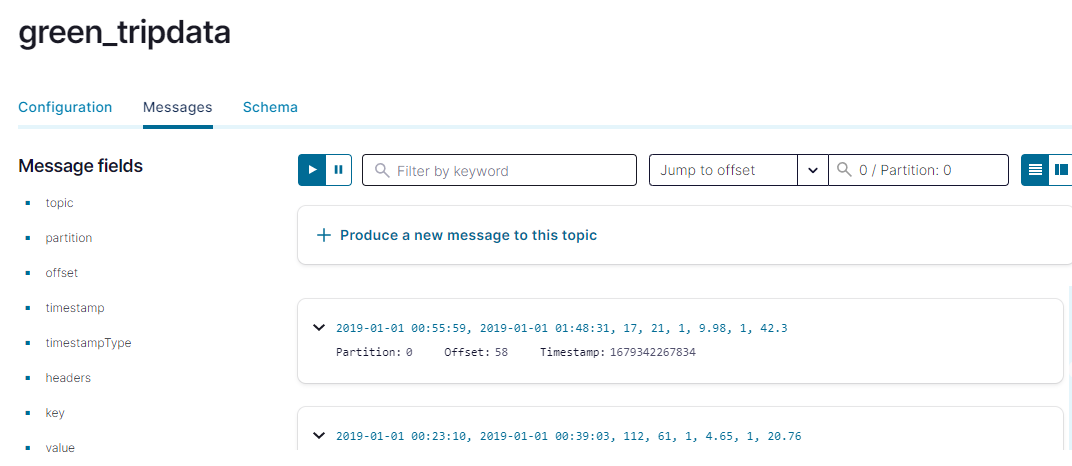

5. Run script [streaming.py](https://github.com/Avisprof/DataEngineering_Zoomcamp/blob/main/week_6_stream_processing/kafka-python-stream/streaming.py) with shell [spark-submit.sh](https://github.com/Avisprof/DataEngineering_Zoomcamp/blob/main/week_6_stream_processing/kafka-python-stream/spark-submit.sh):
<br>`./spark_submit.sh streaming.py`

6. In this script I prepare function __process_stream_data__ that reads two kafka topics and writes both of them in topic __ride_all_count__

In [2]:
def process_stream_data(consume_topic, consume_schema, key_column, source_name, checkpoint):

    # read_streaming data
    df_consume_stream = read_from_kafka(consume_topic=consume_topic)

    # parse streaming data
    df_data = parse_data_from_kafka_message(df_consume_stream, consume_schema)

    #sink_console(df_data, output_mode='append')

    # get aggregated data
    df_agg = df_data \
                .filter(F.col(key_column).isNotNull()) \
                .groupBy(key_column) \
                .count() \
                .withColumnRenamed(key_column,'pickup_id') \
                .withColumn('key', F.col('pickup_id')) \
                .withColumn('source', F.lit(source_name))
    
    # write the output out to the console for debugging / testing
    sink_console(df_agg)

    # prepare data to kafka in the <key, value> forma
    df_trip_count_messages = prepare_df_to_kafka_sink(df=df_agg,
                                                      value_columns=['pickup_id','count','source'], 
                                                      key_column='key') 
    
    # write the output to the kafka topic
    sink_kafka(df=df_trip_count_messages, 
               topic=PRODUCE_TOPIC_RIDE_ALL, 
               output_mode='complete',
               checkpoint=checkpoint)

And apply aggregations to find most popular pickup location.

In [6]:
def main():

    spark = SparkSession.builder.appName('green_tripdata').getOrCreate()
    spark.sparkContext.setLogLevel('WARN')
     
    # process green_tripdata 
    process_stream_data(consume_topic = CONSUME_TOPIC_GREEN, 
                        consume_schema = GREEN_SCHEMA, 
                        key_column = 'PULocationID', 
                        source_name = 'green_tripdata',
                        checkpoint = 'checkpoint_green')

    # process fhv_tripdata
    process_stream_data(consume_topic = CONSUME_TOPIC_FHV, 
                        consume_schema = FHV_SCHEMA, 
                        key_column = 'PUlocationID', 
                        source_name ='fhv_tripdata',
                        checkpoint = 'checkpoint_fhv') 
    
    # find most popular pickup location
    df_ride_all_stream = read_from_kafka(consume_topic=PRODUCE_TOPIC_RIDE_ALL)
    df_ride_all = parse_data_from_kafka_message(df_ride_all_stream, RIDE_ALL_SCHEMA)
    #sink_console(df_ride_all, output_mode='append')

    df_agg = df_ride_all \
               .select(['pickup_id','count']) \
               .groupBy('pickup_id') \
               .agg(F.sum('count').alias('count')) \
               .orderBy(F.col('count').desc())
    sink_console(df_agg)
                         
    spark.streams.awaitAnyTermination()

7. Show topic "__ride_all_count__" in the CONFLUENT (http://localhost:9021)
    
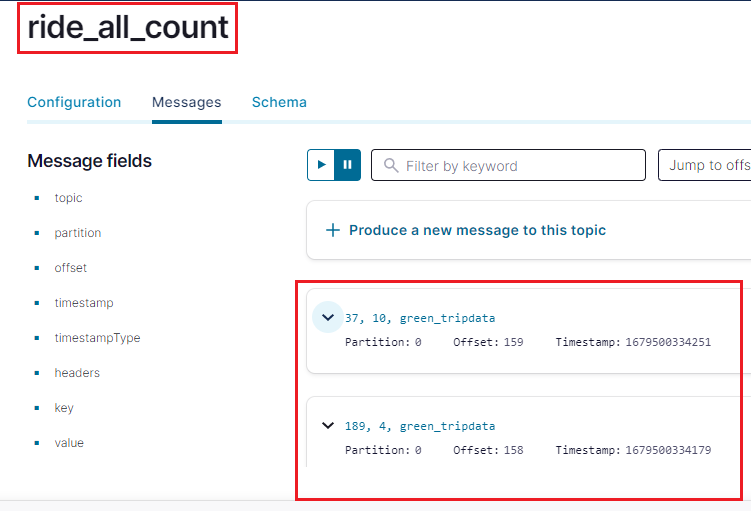

6. Most popular pickup location in the console by __Batch #0__:
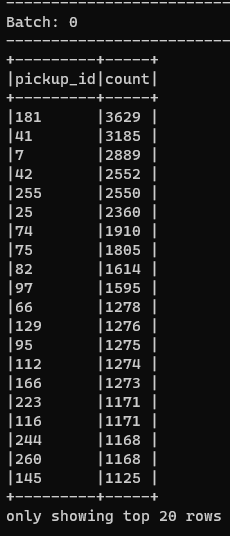

7. Most popular pickup location in the console by __Batch #6__:
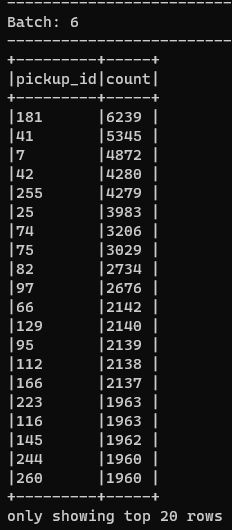